<a href="https://colab.research.google.com/github/PMartey/KaggleX-Project/blob/main/001_Updated_Copy_of_Stock_trading_and_Insurance_Bot_KaggleX_QA_with_Gemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# Download the gemma_2b_en/2 from kaggle

keras_gemma_keras_gemma_2b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_2b_en/2')
#keras_gemma_keras_gemma_instruct_2b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_instruct_2b_en/2')
#keras_gemma_keras_gemma_instruct_7b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_instruct_7b_en/2')
#keras_gemma_keras_gemma_7b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_7b_en/2')

#print('Data source import complete.')

# Google – AI Assistants for Data Tasks with Gemma with [KerasNLP](https://github.com/keras-team/keras-nlp) and [Keras](https://github.com/keras-team/keras)

> The objective of this question and answer model is to build a chatbot to assist individuals in understanding stock trading concepts or answering day to day insurance or stock trading questions

<div align="center">
    <img src="https://thumbs.dreamstime.com/z/financial-money-business-diagram-report-52108082.jpg?ct=jpeg">
</div>

In this project, we will create a notebook that demonstrate how to use the Gemma LLM to accomplish one or more of the following  tasks:
1. **<font color="red">Answer common questions about insurance or trades.</font>**
2. Explain or teach basic trading/insurance concepts.
3. Summarize Solution write-ups.
4. Give insurance market estimates.
5. Answer common questions about what is going on in the stock market.

This notebook guides you through performing `"1. Answer common questions about insurance or trades"` task for the project. As this task requires specific knowledge of the financial markets(banking,stocks,insurance,and shares), we need precise information about Finance. To do so, I have created a dataset, ["Final Training Dataset"], collecting data from [huggingface.com](https://huggingface.co/datasets/yymYYM/stock_trading_QA). To make things easier for the model, the data is curated to have Question-Answer pair format. We will use this dataset to fine-tune **Gemma LLM** to answer questions about stcok trading.

<u>Fun fact</u>: This notebook is backend-agnostic, supporting TensorFlow, PyTorch, and JAX. However, the best performance can be achieved from `JAX`. Utilizing KerasNLP and Keras allows us to choose our preferred backend. Explore more details on [Keras](https://keras.io/keras_3/).

**Note**: For a more in-depth understanding of KerasNLP, refer to the [KerasNLP guides](https://keras.io/keras_nlp/).

# Install Libraries

In [4]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 58.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


# Import Libraries

In [5]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00" # avoid memory fragmentation on JAX backend.

import keras
import keras_nlp

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas() # progress bar for pandas

import plotly.graph_objs as go
import plotly.express as px
from IPython.display import display, Markdown

# Configuration

In [6]:
class CFG:
    seed = 42
    dataset_path = "/content/train1_data.csv"
    preset = "gemma_2b_en" # name of pretrained Gemma #using this instead 'gemma_instruct_2b_en' of 'gemma_2b_en'
    sequence_length = 512 # max size of input sequence for training
    batch_size = 1 # size of the input batch in training, x 2 as two GPUs
    epochs = 25 # number of epochs to train

# Reproducibility
Sets value for random seed to produce similar result in each run.

In [7]:
keras.utils.set_random_seed(CFG.seed)

# Data

The newly created **STand I-questions-and-answers** dataset contains only approximately $198$ question-answer pairs curated from raw data from the `huggingface.com` website. However, one can create many more samples from this provided data through simple augmentation or prompt engineering.  In this notebook, we will focus on keeping it simple.

**Data Format:**

- The question-answer pair data is stored in `/kaggle/input/provide link` file.
- This file includes:
    - `Question`: A question about banking,stocks, insurance, and shares
    - `Answer`: Answer to the question in markdown format
    
> You can access the **raw** data from `hugging face`, where there are `.parquet and .csv` files for each of the **two** categories.

In [8]:
df_train = pd.read_csv(f"{CFG.dataset_path}")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  198 non-null    object
 1   answer    198 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [9]:
# Randomly select 250 rows from my data set since training on all 12047 rows takes more storage
#df = df_train.sample(n=100, random_state=42)
#print(df.info())
#df.head(2)
df = df_train


We'll use the following simple template to create prompts from question-answer pairs and category to feed text into the model:

```

Question: ...

Answer: ...
```

This template helps the model understand what you're asking and how to respond accurately. You can explore more advanced prompt templates for better results.

In [10]:
# Loading validation data set
df_val1 = pd.read_csv("/content/val1_data.csv")
df_val1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  42 non-null     object
 1   answer    42 non-null     object
dtypes: object(2)
memory usage: 800.0+ bytes


In [11]:
template = "\n\nQuestion:\nUser-{Question}\n\nAnswer:\n{Answer}"

In [12]:
df["prompt"] = df.progress_apply(lambda row: template.format(
                                                             Question=row.question,
                                                             Answer=row.answer), axis=1)
data = df.prompt.tolist()


  0%|          | 0/198 [00:00<?, ?it/s]

In [13]:
df_val1["prompt"] = df.progress_apply(lambda row: template.format(
                                                             Question=row.question,
                                                             Answer=row.answer), axis=1)

df_val = df_val1.prompt.tolist()

  0%|          | 0/198 [00:00<?, ?it/s]

Let's examine a sample prompt. As the answers in our dataset are curated with **markdown** format, we will render the sample using `Markdown()` to properly visualize the formatting.

## Sample

In [14]:
def colorize_text(text):
    for word, color in zip(["Question", "Answer"], ["red", "green"]):
        text = text.replace(f"\n\n{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
    return text

In [15]:
# Take a random sample
sample = data[45]

# Give colors to Question, Answer and Category
sample = colorize_text(sample)

# Show sample in markdown
display(Markdown(sample))  # this is an incomplete answer



**<font color='red'>Question:</font>**
User-What role does the exchange rate play in trading models integrating macroeconomic indicators?

**<font color='green'>Answer:</font>**
Exchange rates impact international trade, capital flows, and competitiveness, making them significant for traders assessing market opportunities and risks.

## Word Cloud
Let's do a simple EDA to determine the most common areas of questions asked.

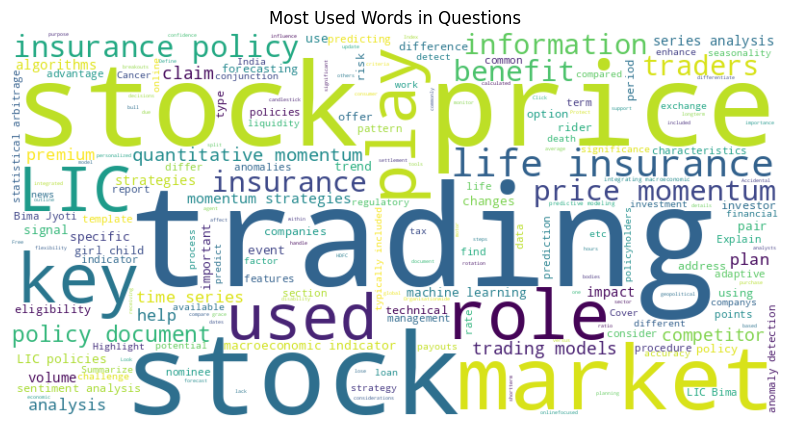

In [16]:
# Create a word cloud for my most asked questions
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#join all the real news
question_tags = ' '.join(list(df['question']))

# create word cloud for real news
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(question_tags)

# plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Used Words in Questions')
plt.show()

# Modeling

## Gemma Casual LM

In [17]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

## Gemma LM Preprocessor

In [18]:
x, y, sample_weight = gemma_lm.preprocessor(data[0:1])

This preprocessing layer will take in batches of strings, and return outputs in a `(x, y, sample_weight)` format, where the `y` label is the next token id in the `x` sequence.

From the code below, we can see that, after the preprocessor, the data shape is `(num_samples, sequence_length)`.

In [19]:
# preprocess validation data
x_val, y_val, sample_weight_val = gemma_lm.preprocessor(df_val[0:1])

In [20]:
# Display the shape of each processed output
for k, v in x.items():
    print(k, ":", v.shape)

token_ids : (1, 1024)
padding_mask : (1, 1024)


# Inference before fine tuning

Let's ask the Gemma model some sample questions using our prepared prompt and see how it responds.

> As this model is not tuned for instruction yet, you will notice that the model is creating more question-answer pairs instead of answering the question that was asked.

## Sample 1

In [21]:
# Take one sample
row = df.iloc[2]

# Generate Prompt using template
prompt = template.format(
   # Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
User-What information is typically included in a certificate of insurance template?

**<font color='green'>Answer:</font>**
The certificate of insurance template should include the following information:

* The name of the insurance company
* The policy number
* The policy expiration date
* The policy limits
* The name of the insured
* The name of the insured’s agent
* The name of the insured’s broker
* The name of the insured’s attorney
* The name of the insured’s accountant
* The name of the insured’s auditor
* The name of the insured’s bank
* The name of the insured’s broker
* The name of the insured’s broker
* The name of the insured’s broker
* The name of the insured’s broker
* The name of the insured’s broker
* The name of the insured’s broker
* The name of the insured’s broker
* The name of the insured’s broker
* The name of the insured’s broker
* The name of the insured’s broker
* The name of the insured’s broker
* The name of the insured’s broker
* The name of the insured’s broker


## Sample 2

In [22]:
# Take one sample
row = df.iloc[45]

# Generate Prompt using template
prompt = template.format(
   # Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))  # This response does not add up



**<font color='red'>Question:</font>**
User-What role does the exchange rate play in trading models integrating macroeconomic indicators?

**<font color='green'>Answer:</font>**
The exchange rate is a key determinant of the value of a country’s exports and imports. It is also a key determinant of the value of a country’s currency. The exchange rate is determined by the supply and demand for a country’s currency. The supply of a country’s currency is determined by the amount of foreign currency that is available to be exchanged for a country’s currency. The demand for a country’s currency is determined by the amount of foreign currency that is available to be exchanged for a country’s currency. The exchange rate is determined by the supply and demand for a country’s currency. The exchange rate is determined by the supply and demand for a country’s currency. The exchange rate is determined by the supply and demand for a country’s currency. The exchange rate is determined by the supply and demand for a country’s currency. The exchange rate is determined by the supply and demand for a country’s currency. The exchange rate is determined by the supply and demand for a country’s currency. The exchange rate is determined by the supply and demand for a country’s currency. The exchange

# Bleu and rouge scores before fine tuning

In [23]:
# prompt: ## find bleu and rouge scores of the output

!pip install rouge_score
!pip install sacrebleu



  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=5b7289fb99ba0cf53a5e17712e744ef6ac2332a1e4d8b12be40665f7132e5aa9
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.5 MB/s eta 0:00:00


In [24]:
!pip install nltk

In [25]:
# sample1

quest1= df.loc[2, 'question']
ans1= df.loc[2, 'answer']

mod_res1= gemma_lm.generate(quest1, max_length=256)
#

In [26]:
# prompt: find rouge score and bleu score

from rouge_score import rouge_scorer
from sacrebleu.metrics import BLEU

# Initialize scorers
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
bleu = BLEU()

# Sample 1
quest1 = df.loc[2, 'question']
ans1 = df.loc[2, 'answer']
mod_res1 = gemma_lm.generate(quest1, max_length=256)

# Calculate ROUGE scores
scores1 = scorer.score(ans1, mod_res1)
print("ROUGE scores for sample 1:")
print(scores1)

# Calculate BLEU score
bleu_score1 = bleu.sentence_score(mod_res1, [ans1])
print(f"\nBLEU score for sample 1: {bleu_score1}")

# Sample 2 (similarly for other samples)
quest2 = df.loc[45, 'question']
ans2 = df.loc[45, 'answer']
mod_res2 = gemma_lm.generate(quest2, max_length=256)

# Calculate ROUGE scores
scores2 = scorer.score(ans2,mod_res2)
print("\nROUGE scores for sample 2:")
print(scores2)

# Calculate BLEU score
bleu_score2 = bleu.sentence_score(mod_res2, [ans2])
print(f"\nBLEU score for sample 2: {bleu_score2}")

ROUGE scores for sample 1:
{'rouge1': Score(precision=0.14678899082568808, recall=0.3404255319148936, fmeasure=0.20512820512820515), 'rougeL': Score(precision=0.11009174311926606, recall=0.2553191489361702, fmeasure=0.15384615384615385)}

BLEU score for sample 1: BLEU = 1.71 8.7/2.3/0.9/0.5 (BP = 1.000 ratio = 4.192 hyp_len = 218 ref_len = 52)



ROUGE scores for sample 2:
{'rouge1': Score(precision=0.05405405405405406, recall=0.3157894736842105, fmeasure=0.09230769230769233), 'rougeL': Score(precision=0.04504504504504504, recall=0.2631578947368421, fmeasure=0.07692307692307693)}

BLEU score for sample 2: BLEU = 0.45 3.2/0.5/0.2/0.1 (BP = 1.000 ratio = 9.478 hyp_len = 218 ref_len = 23)


# Fine-tuning with LoRA

In [27]:
# Enable LoRA for the model and set the LoRA rank to 10.
gemma_lm.backbone.enable_lora(rank=10)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,509,582,336 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,509,582,336 (9.35 GB)

 Trainable params: 3,409,920 (13.01 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

**Notice** that, the number of trainable parameters is reduced from ~$2.5$ billions to ~$3.4$ millions after enabling LoRA.

## Training

In [28]:

# Limit the input sequence length to 512 (to control memory usage).
gemma_lm.preprocessor.sequence_length = CFG.sequence_length

import tensorflow as tf

# Set up a learning rate schedule with a warm-up phase
initial_learning_rate = 8e-5
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)


# Compile the model with loss, optimizer, and metric
gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


In [29]:
import random

# Sample size
sample_size = 50

# Training loop
for epoch in range(CFG.epochs):
    # Sample 50 random entries from the list
    sampled_data = random.sample(data, sample_size)

    print(f"Epoch {epoch + 1}: Training on {sample_size} samples")

    # Train the model using the sampled data
    gemma_lm.fit(
        sampled_data,
        #steps_per_epoch=steps_per_epoch,
        epochs= 1,  # Train for one epoch on the sampled data
        batch_size=CFG.batch_size,
        # validation_data=df_val,
        # validation_split=0.2,  # Use 20% of the data for validation
        # callbacks=[checkpoint]
    )


Epoch 1: Training on 50 samples
50/50 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - loss: 0.4226 - sparse_categorical_accuracy: 0.4690
Epoch 2: Training on 50 samples
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 0.3982 - sparse_categorical_accuracy: 0.5441
Epoch 3: Training on 50 samples
50/50 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 0.2516 - sparse_categorical_accuracy: 0.5758
Epoch 4: Training on 50 samples
50/50 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 0.2470 - sparse_categorical_accuracy: 0.6048
Epoch 5: Training on 50 samples
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 0.3663 - sparse_categorical_accuracy: 0.5718
Epoch 6: Training on 50 samples
50/50 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 0.2604 - sparse_categorical_accuracy: 0.6092
Epoch 7: Training on 50 samples
50/50 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 0.3232 - sparse_categorical_accuracy: 0.5668
Epoch 8: Training on 50 samples
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 0.4006 - sparse_categorical_accuracy: 0.5591
Epoch 9

# Inference after fine-tuning

Let's see how our fine-tuned model responds to the same questions we asked before fine-tuning the model.

## Sample 1

In [30]:
# Take one sample
row = df.iloc[2]

# Generate Prompt using template
prompt = template.format(
   # Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
User-What information is typically included in a certificate of insurance template?

**<font color='green'>Answer:</font>**
A certificate of insurance template typically includes the following information: - Policy number - Policyholder name and address - Policy expiration date - Policy limits and coverage details - Policyholder contact information - Policyholder signature and date - Insurer name and address - Insurer contact information - Policyholder signature and date

## Sample 2

In [31]:
# Take one sample
row = df.iloc[45]

# Generate Prompt using template
prompt = template.format(
    #Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
User-What role does the exchange rate play in trading models integrating macroeconomic indicators?

**<font color='green'>Answer:</font>**
The exchange rate plays a crucial role in trading models integrating macroeconomic indicators. Changes in the value of a country's currency can impact the competitiveness of its exports, influencing the demand for its goods and services, and affecting the overall economic performance of the country.

## Unseen Sample

Also just for fun, let's try out a question that model hasn't seen during training.

In [32]:
# Generate Prompt using template
prompt = template.format(
    #Category="kaggle-notebook",
    Question="When is a good time to enter a trade",
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
User-When is a good time to enter a trade

**<font color='green'>Answer:</font>**
A good time to enter a trade is when the market sentiment is bullish, momentum is building, and technical indicators suggest a potential uptrend. Entering a trade at the right time can help lock in profits or minimize losses during a market correction.

Scores after finetuning

In [36]:
# prompt: find rouge score and bleu score

from rouge_score import rouge_scorer
from sacrebleu.metrics import BLEU

# Initialize scorers
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
bleu = BLEU()

# Sample 1
quest1 = df.loc[2, 'question']
ans1 = df.loc[2, 'answer']
mod_res1 = gemma_lm.generate(quest1, max_length=256)

# Calculate ROUGE scores
scores1 = scorer.score(ans1, mod_res1)
print("ROUGE scores for sample 1:")
print(scores1)

# Calculate BLEU score
bleu_score1 = bleu.sentence_score(mod_res1, [ans1])
print(f"\nBLEU score for sample 1: {bleu_score1}")

# Sample 2 (similarly for other samples)
quest2 = df.loc[45, 'question']
ans2 = df.loc[45, 'answer']
mod_res2 = gemma_lm.generate(quest2, max_length=256)

# Calculate ROUGE scores
scores2 = scorer.score(ans2,mod_res2)
print("\nROUGE scores for sample 2:")
print(scores2)

# Calculate BLEU score
bleu_score2 = bleu.sentence_score(mod_res2, [ans2])
print(f"\nBLEU score for sample 2: {bleu_score2}")

ROUGE scores for sample 1:
{'rouge1': Score(precision=0.13559322033898305, recall=0.3404255319148936, fmeasure=0.19393939393939394), 'rougeL': Score(precision=0.11016949152542373, recall=0.2765957446808511, fmeasure=0.1575757575757576)}

BLEU score for sample 1: BLEU = 2.25 12.4/2.1/1.4/0.7 (BP = 1.000 ratio = 2.788 hyp_len = 145 ref_len = 52)



ROUGE scores for sample 2:
{'rouge1': Score(precision=0.029787234042553193, recall=0.3684210526315789, fmeasure=0.05511811023622048), 'rougeL': Score(precision=0.029787234042553193, recall=0.3684210526315789, fmeasure=0.05511811023622048)}

BLEU score for sample 2: BLEU = 0.24 3.2/0.2/0.1/0.1 (BP = 1.000 ratio = 10.783 hyp_len = 248 ref_len = 23)


In [37]:
# Save my model as a preset
!mkdir STIbot_my_gemma2_pt # Create the directory
gemma_lm.save_to_preset(f"./Updated_STIbot_my_gemma2_pt") # Save the model to the directory as a preset

# Upload the model to Kaggle
my_user_name = "dedemartey"
my_model_name = "Updated_STIbot_my_gemma2_pt"
kaggle_uri = f"kaggle://{my_user_name}/gemma/keras/{my_model_name}"
keras_nlp.upload_preset(kaggle_uri, f"./{my_model_name}")

Uploading Model https://www.kaggle.com/models/dedemartey/gemma/keras/Updated_STIbot_my_gemma2_pt ...
Starting upload for file ./Updated_STIbot_my_gemma2_pt/model.weights.h5


Uploading: 100%|██████████| 10.0G/10.0G [02:01<00:00, 82.8MB/s]

Upload successful: ./Updated_STIbot_my_gemma2_pt/model.weights.h5 (9GB)
Starting upload for file ./Updated_STIbot_my_gemma2_pt/config.json



Uploading: 100%|██████████| 785/785 [00:00<00:00, 4.32kB/s]

Upload successful: ./Updated_STIbot_my_gemma2_pt/config.json (785B)
Starting upload for file ./Updated_STIbot_my_gemma2_pt/metadata.json



Uploading: 100%|██████████| 143/143 [00:00<00:00, 802B/s]

Upload successful: ./Updated_STIbot_my_gemma2_pt/metadata.json (143B)
Starting upload for file ./Updated_STIbot_my_gemma2_pt/preprocessor.json



Uploading: 100%|██████████| 1.41k/1.41k [00:00<00:00, 7.93kB/s]

Upload successful: ./Updated_STIbot_my_gemma2_pt/preprocessor.json (1KB)
Starting upload for file ./Updated_STIbot_my_gemma2_pt/task.json



Uploading: 100%|██████████| 2.98k/2.98k [00:00<00:00, 16.3kB/s]

Upload successful: ./Updated_STIbot_my_gemma2_pt/task.json (3KB)
Starting upload for file ./Updated_STIbot_my_gemma2_pt/tokenizer.json



Uploading: 100%|██████████| 591/591 [00:00<00:00, 3.30kB/s]

Upload successful: ./Updated_STIbot_my_gemma2_pt/tokenizer.json (591B)
Starting upload for file ./Updated_STIbot_my_gemma2_pt/assets/tokenizer/vocabulary.spm



Uploading: 100%|██████████| 4.24M/4.24M [00:00<00:00, 17.6MB/s]

Upload successful: ./Updated_STIbot_my_gemma2_pt/assets/tokenizer/vocabulary.spm (4MB)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/dedemartey/gemma/keras/Updated_STIbot_my_gemma2_pt


In [34]:
# Upload model to hugging face to
my_user_name = "Dede29"
my_model_name = "STIbot_my_gemma2_pt"